In [1]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import numba
from collections import Counter
import math
import sklearn
import sklearn.metrics
import sklearn.ensemble
import scipy.sparse
import keras
import sys
import pickle
sys.path += ["../test"]
from train_clustering import encode_triu, decode_triu
from train_regression import get_unique_X_y

from matplotlib.colors import LogNorm

Using TensorFlow backend.


setGPU: Setting GPU to: 0


In [43]:
@numba.njit
def get_types_in_block(X, y, blk):
    return [int(x) for x in sorted(X[y==blk, 0])]

def get_blocksize_candsize_matrix(el_bl_id, cand_bl_id):
    blids = np.unique(el_bl_id)
    sizes = np.zeros((len(blids), 2), dtype=np.float32)
    i = 0
    els_counter = Counter(el_bl_id)
    cands_counter = Counter(cand_bl_id)
    for bl in blids:
        sizes[i, 0] = els_counter[bl]
        sizes[i, 1] = cands_counter[bl]
        i += 1
        
    b = np.linspace(0,20,21)
    c, _, _ = np.histogram2d(sizes[:, 0], sizes[:, 1], bins=(b, b))
    return c

Load all elements

In [54]:
all_sgs = []

num_clusters = []
num_tracks = []
num_cands = []
num_blocks = []

blsize_candsize_matrices = []

for fi in glob.glob("../data/TTbar/*ev*.npz"):
    fi = open(fi, "rb")
    data = np.load(fi)
    
    #list of PF input elements in the event
    X = data["elements"]
    
    #tracks have type=1
    num_clusters += [np.sum(X[:, 0] != 1)]
    num_tracks += [np.sum(X[:, 0] == 1)]
    
    #unique ID for each cluster/block of elements that the PFAlgo considered independently
    #this can be considered as the target output of an improved PFBlockAlgo
    y = data["element_block_id"]
    num_blocks += [len(np.unique(y))]

    #List of candidates produced in the event.
    #This can be considered as the output of PFAlgo
    cands = data["candidates"]
    num_cands += [len(cands)]

    #get the types of the elements for each cluster/block
    sgs = [tuple(get_types_in_block(X, y, blk)) for blk in np.unique(y)]
    all_sgs += sgs
    
    blsize_candsize_matrices += [get_blocksize_candsize_matrix(data["element_block_id"], data["candidate_block_id"])]

In [60]:
bins = np.linspace(0,20,21)

Text(0, 0.5, 'number of elements in block')

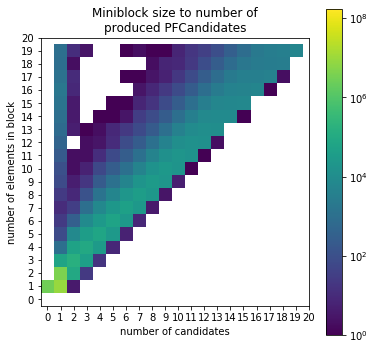

In [61]:
plt.figure(figsize=(6,6))
cmat = sum(blsize_candsize_matrices)
plt.imshow(cmat, norm=LogNorm(vmin=1, vmax=10*np.sum(cmat)), origin="lower", interpolation=None)

plt.colorbar()
plt.xticks(bins);
plt.yticks(bins);

plt.title("Miniblock size to number of\nproduced PFCandidates")
plt.xlabel("number of candidates")
plt.ylabel("number of elements in block")

(0, 3)

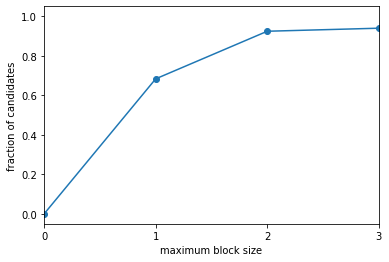

In [57]:
plt.plot(bins[:-1], cmat.sum(axis=1).cumsum()/np.sum(cmat), marker="o")
plt.xticks(bins);
plt.xlabel("maximum block size")
plt.ylabel("fraction of candidates")
plt.xlim(0,3)

(2, 20)

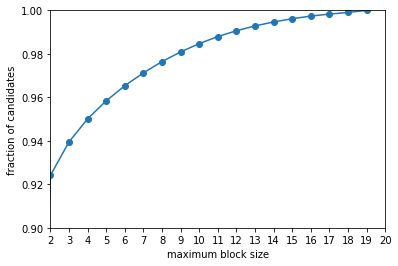

In [58]:
plt.plot(bins[:-1], cmat.sum(axis=1).cumsum()/np.sum(cmat), marker="o")
plt.xticks(bins);
plt.xlabel("maximum block size")
plt.ylabel("fraction of candidates")
plt.ylim(0.9, 1.0)
plt.xlim(2,20)

Text(0, 0.5, 'number of events')

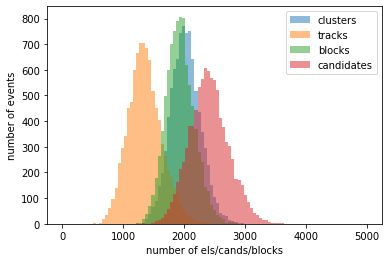

In [67]:
plt.hist(num_clusters, bins=np.linspace(0, 5000, 100), label="clusters", alpha=0.5);
plt.hist(num_tracks, bins=np.linspace(0, 5000, 100), label="tracks", alpha=0.5);
plt.hist(num_blocks, bins=np.linspace(0, 5000, 100), label="blocks", alpha=0.5);
plt.hist(num_cands, bins=np.linspace(0, 5000, 100), label="candidates", alpha=0.5);
plt.legend()
plt.xlabel("number of els/cands/blocks")
plt.ylabel("number of events")

Now we look at the number of blocks of a certain size.

In [7]:
block_sizes = Counter([len(sg) for sg in all_sgs])
print("block sizes", block_sizes)

block sizes Counter({1: 133092, 2: 46733, 3: 3016, 4: 2066, 5: 1567, 6: 1343, 7: 1126, 8: 1020, 9: 852, 10: 718, 11: 622, 12: 505, 13: 392, 14: 378, 15: 290, 16: 255, 17: 197, 18: 137, 19: 120, 20: 71, 21: 48, 22: 42, 23: 37, 24: 30, 25: 29, 26: 16, 29: 10, 28: 10, 32: 10, 27: 8, 31: 7, 30: 5, 35: 5, 41: 4, 39: 2, 36: 2, 54: 2, 34: 2, 49: 2, 52: 2, 43: 1, 51: 1, 48: 1, 40: 1, 65: 1, 61: 1, 42: 1, 33: 1})


Text(0, 0.5, 'Number of blocks')

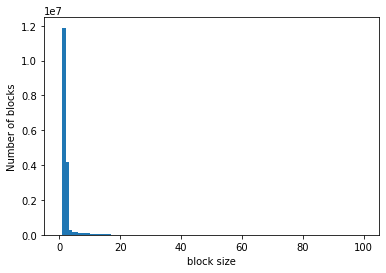

In [68]:
plt.hist([len(sg) for sg in all_sgs], bins=np.linspace(0,100,101));
plt.xlabel("block size")
plt.ylabel("Number of blocks")

Text(0, 0.5, 'number of blocks')

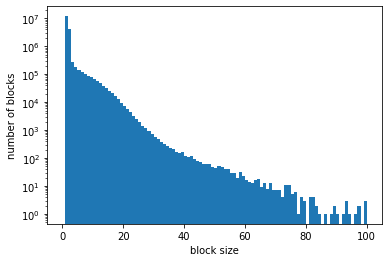

In [69]:
plt.hist([len(sg) for sg in all_sgs], bins=np.linspace(0,100,101));
plt.yscale("log")
plt.xlabel("block size")
plt.ylabel("number of blocks")

Let's look at what the blocks f size, 1, 2, 3 and 4 are made of.

1-element blocks Counter({'1': 3730164, '4': 2638666, '8': 1687262, '9': 1427830, '3': 1073842, '2': 880659, '5': 439025, '11': 11392})
2-element blocks Counter({'8,9': 3640303, '1,5': 327267, '1,4': 210710, '5,11': 11679, '4,4': 72, '4,5': 9, '1,1': 6, '3,4': 6, '2,4': 2})
3-element blocks Counter({'1,1,5': 179626, '1,4,5': 72010, '1,4,4': 7506, '1,1,4': 7332, '1,5,11': 886, '5,11,11': 516, '4,4,4': 39, '1,1,1': 35, '2,3,4': 2, '3,3,4': 1, '3,4,4': 1})
4-element blocks Counter({'1,1,1,5': 114420, '1,1,4,5': 63834, '1,4,4,5': 3096, '1,1,1,4': 1702, '1,4,5,11': 722, '1,1,5,11': 417, '1,1,4,4': 286, '1,4,4,4': 77, '4,4,4,4': 23, '5,11,11,11': 19, '1,5,5,11': 8, '1,5,11,11': 2, '1,1,1,1': 1})


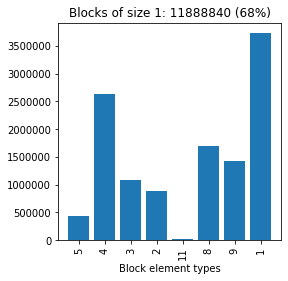

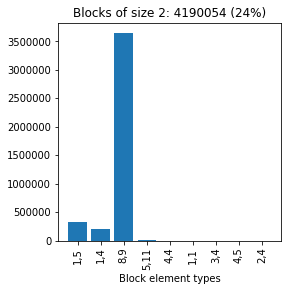

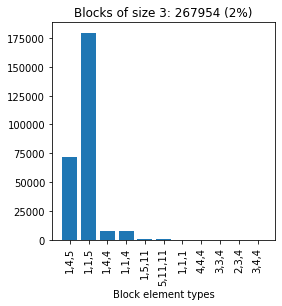

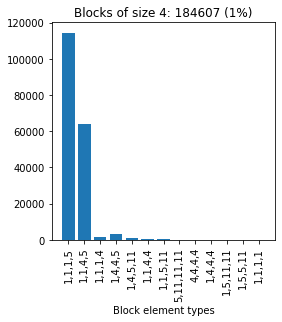

In [70]:
def plot_block_nelem(blocks_nelem):
    kv = list(blocks_nelem.items())
    xs = np.arange(len(kv))
    ys = np.array([v for k, v in kv])

    plt.bar(xs, ys)
    plt.xticks(xs, [k for k, v in kv], rotation=90)
    

for blocksize in range(1,5):
    sizes = [",".join(map(str, sg)) for sg in all_sgs if len(sg)==blocksize]
    blocks_nelem = Counter(sizes)
    print("{0}-element blocks".format(blocksize), blocks_nelem)
    plt.figure(figsize=(4,4))
    plt.title("Blocks of size {0}: {1} ({2:.0f}%)".format(blocksize, len(sizes), 100.0*len(sizes)/len(all_sgs)))
    plot_block_nelem(blocks_nelem)
    plt.xlabel("Block element types")

Look at the first 10 blocks.

In [11]:
block_ids = data["element_block_id"]
inds_elem = np.arange(len(X))
inds_cand = np.arange(len(cands))
for blk in np.unique(block_ids)[:20]:
    candidates_from_block = data["candidate_block_id"] == blk
    elems_in_block = y == blk
    
    print("in block", blk, "had the following elements: {0}".format(get_types_in_block(X, y, blk)))
    for ielem in inds_elem[elems_in_block]:
        print("  elements[{0}]: type={1} energy={2:.2f}".format(ielem, int(X[ielem, 0]), X[ielem, 1]))
    print("from which the following candidates were produced")
    for icand in inds_cand[candidates_from_block]:
        print("  candidates[{0}]: pdgid={1} pt={2:.2f}".format(icand, int(cands[icand, 0]), cands[icand, 1]))
    print()

in block 0 had the following elements: [1, 5]
  elements[0]: type=5 energy=1.42
  elements[1886]: type=1 energy=-0.36
from which the following candidates were produced
  candidates[584]: pdgid=-211 pt=0.95

in block 1 had the following elements: [1, 5]
  elements[1]: type=5 energy=3.93
  elements[1874]: type=1 energy=-0.53
from which the following candidates were produced
  candidates[616]: pdgid=-211 pt=0.93

in block 2 had the following elements: [1, 1, 1, 4, 5]
  elements[2]: type=5 energy=1.64
  elements[102]: type=4 energy=0.95
  elements[1770]: type=1 energy=0.19
  elements[1793]: type=1 energy=-0.64
  elements[1851]: type=1 energy=-0.45
from which the following candidates were produced
  candidates[249]: pdgid=211 pt=1.56
  candidates[764]: pdgid=-211 pt=0.79
  candidates[865]: pdgid=-211 pt=0.71

in block 3 had the following elements: [5]
  elements[3]: type=5 energy=1.54
from which the following candidates were produced
  candidates[1051]: pdgid=130 pt=0.59

in block 4 had the